In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as fp
from PIL import Image

In [2]:
#Linear Filtering Method from HW1 

def filt(image, kernel, rgb=False):
    image_dims = image.shape
    kernel_dims = kernel.shape
    out = np.zeros((image.shape[0] - kernel.shape[0], image.shape[1] - kernel.shape[1]))
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    if rgb:
                        out[i][j] += (image[i+k][j+l]*kernel[k][l]) / 255
                    else:
                        out[i][j] += (image[i+k][j+l]*kernel[k][l])
    return out

In [3]:
#Problem 1 - create a my_imfilter function
def my_imfilter(image, kernel):
    kernel_dims = kernel.shape
    image_dims = image.shape
    dims = len(image_dims)
    #Test to see if the kernel's length and with are both odd
    if kernel_dims[0] % 2 == 0 or kernel_dims[1] % 2 == 0:
        raise ValueError("Both Kernel Dimensions Must Be Odd")
    #Test to see if image is RGB or grayscale
    if dims < 2 or dims > 3:
        raise ValueError("Only Grayscale and RGB Images are Supported")
    
    #Gray scale image
    if dims == 2:
        print("Image is grayscale")
        image = np.pad(image, ((kernel.shape[0]//2, kernel.shape[0]//2+1), 
                               (kernel.shape[1]//2, kernel.shape[1]//2+1)))
        out = filt(image, kernel)
    #RBG Image - same as grayscale convolution except repeated over three channels
    if dims == 3:
        print("Image is RGB")
        r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        b = np.pad(b, ((kernel.shape[0]//2, kernel.shape[0]//2+1), 
                            (kernel.shape[1]//2, kernel.shape[1]//2+1)))
        g = np.pad(g, ((kernel.shape[0]//2, kernel.shape[0]//2+1), 
                            (kernel.shape[1]//2, kernel.shape[1]//2+1)))
        r = np.pad(r, ((kernel.shape[0]//2, kernel.shape[0]//2+1), 
                            (kernel.shape[1]//2, kernel.shape[1]//2+1)))
    
        b_conv = filt(b, kernel)
        g_conv = filt(g, kernel)
        r_conv = filt(r, kernel)
    
        
        out = np.dstack((r_conv, g_conv, b_conv))
        
    return out

Image is RGB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Image Shape: (400, 400, 3)
Output Image Shape: (400, 400, 3)
Output Shape = Input Shape? True


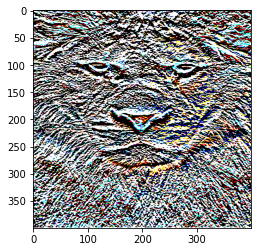

In [4]:
def main():
    gray = cv2.imread("Image3.jpg")
    gray = cv2.resize(gray, (400, 400))
    kernel1 = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    kernel2 = np.array([[1, 1, 1], [0, 0, 0], [1, 1, 1], [0, 0, 0], [1, 1, 1]])
    out = my_imfilter(gray, kernel1)
    print("Original Image Shape: " + str(gray.shape)) 
    print("Output Image Shape: " + str(out.shape))
    print("Output Shape = Input Shape? " + str((out.shape==gray.shape)))
    plt.imshow(out)
    
main()

In [5]:
def gaussian_pyramid(image, level):
    pyramid = [image]
    for i in range(level):
        image = cv2.pyrDown(image)
        pyramid.append(image)
        
    return pyramid

def laplacian_pyramid(image, level):
    gpyr = gaussian_pyramid(image, level)
    pyramid = [gpyr[-1]]
    for i in range(level-1,0,-1):
        size = (gpyr[i - 1].shape[1], gpyr[i - 1].shape[0])
        laplacian = np.subtract(gpyr[i-1], cv2.pyrUp(gpyr[i], dstsize=size))
        pyramid.append(laplacian)
    return pyramid
    

In [6]:
#Problem 2 - pair 1

#Creates gaussian filter of a given size - tuple
def low_filter(image, kernel_size, sigma):
    filt = np.zeros((kernel_size[0], kernel_size[1]))
    for i in range(kernel_size[0]):
        for j in range(kernel_size[1]):
            filt[i, j] = (1 / (2*np.pi*sigma))*np.exp(-1*(i**2 + j**2)/ (2*sigma**2))
    return my_imfilter(image, filt)
    
def high_filter(image, kernel_size, sigma):
    gaussian = low_filter(image, kernel_size, sigma)
    return image - gaussian

def hybrid(image1, image2, sigma1, sigma2):
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
        
    KERNEL_SIZE = (5, 5)
    lowpass = low_filter(image1, KERNEL_SIZE , sigma1)
    highpass = high_filter(image2, KERNEL_SIZE, sigma2)
    hybrid = lowpass + highpass

    return hybrid


Image is grayscale
Image is grayscale


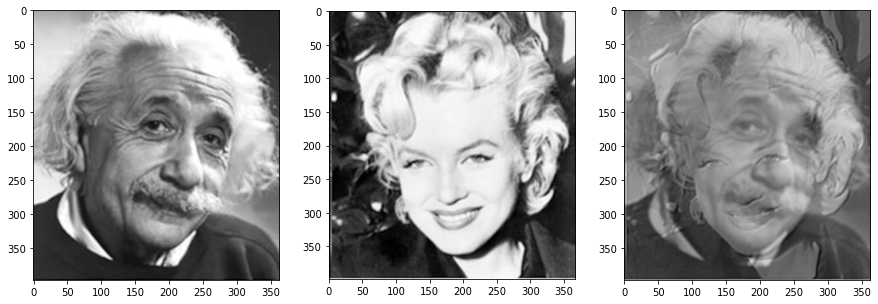

<Figure size 720x1080 with 0 Axes>

In [15]:
gray1 = cv2.imread("Image1.png", 0)
gray2 = cv2.imread("Image2.png", 0)
gray_hybrid = hybrid(gray1, gray2, 4, 2)
fig, ax = plt.subplots(1, 3)
plt.figure(figsize=(10, 15))
fig.set_figheight(15)
fig.set_figwidth(15)
ax[0].imshow(gray1, "gray")
ax[1].imshow(gray2, "gray")
ax[2].imshow(gray_hybrid, "gray")


Image is RGB
Image is RGB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


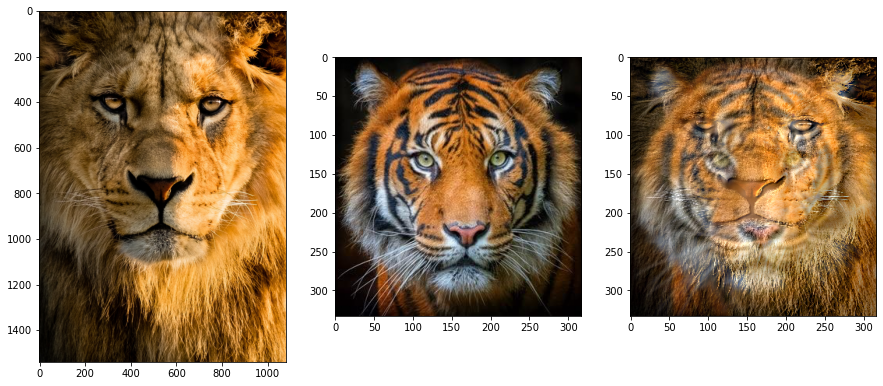

In [16]:
color1 = cv2.imread("Image3.jpg")
color1 = cv2.cvtColor(color1, cv2.COLOR_BGR2RGB)
color1 = color1/255
color2 = cv2.imread("Image4.png")
color2 = cv2.cvtColor(color2, cv2.COLOR_BGR2RGB)
color2 = color2/255
# color1 = cv2.resize(color1, (400, 400))
# color2 = cv2.resize(color2, (400, 400))
hybrid_rgb = hybrid(color2, color1, 4, 1)
fig, ax = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(15)
ax[0].imshow(color1)
ax[1].imshow(color2)
ax[2].imshow(hybrid_rgb)

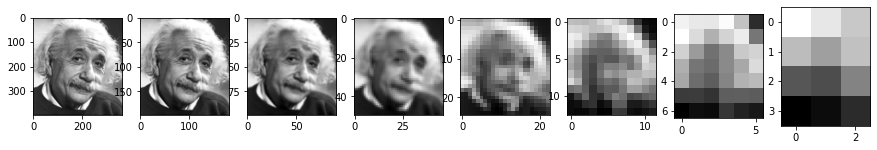

In [9]:
LEVEL = 8
fig, ax = plt.subplots(1, LEVEL)
fig.set_figheight(15)
fig.set_figwidth(15)
gray1 = cv2.imread("Image1.png", 0)
gpyr = gaussian_pyramid(gray1, LEVEL)
for i in range(LEVEL):
    ax[i].imshow(gpyr[i], cmap="gray")


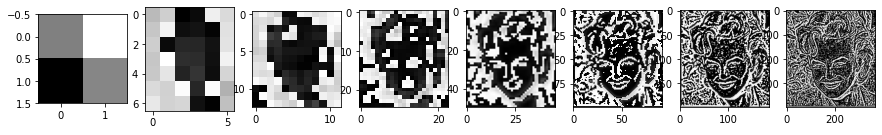

In [10]:
LEVEL = 8
fig, ax = plt.subplots(1, LEVEL)
fig.set_figheight(15)
fig.set_figwidth(15)
gray2 = cv2.imread("Image2.png", 0)
lpyr = laplacian_pyramid(gray2, LEVEL)
for i in range(LEVEL):
    ax[i].imshow(lpyr[i], cmap="gray")